In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import *
from tensorflow.keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers,losses
from keras.utils import to_categorical
import keras.backend as kb
from nltk.corpus import words
import random as rand
import spacy
import re
from tqdm import tqdm
import scipy.stats as ss
import seaborn as sns

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv')
test = pd.read_csv('../input/tweet-sentiment-extraction/test.csv')

#test data frame doens't have a selected text column, so it's created to be later filled
test["selected_text"]=""

In [3]:
train.sample(5)

,textID,text,selected_text,sentiment
15304,2d6e96cb85,No more Wiffleball.. ****.,****.,negative
5118,b2ca6221e6,Doing really well! I will stay here as long a...,Doing really well!,positive
9057,f40b6c405c,doesn`t wanna get dressed up and be an adult t...,doesn`t wanna get dressed up an,negative
873,2554631fd6,_beery Yeah little rough this morning but more...,rough,negative
18676,257010ac59,Work around the house boo,boo,negative


# We will do some EDA to get further insight about our data

In [4]:
print("ratio of each sentiment relative to total number of tweets:")
train_relative_count=train.sentiment.value_counts(normalize=True)
test_relative_count=test.sentiment.value_counts(normalize=True)
print("train data:\n",train_relative_count)
print("test data:\n",test_relative_count)

ratio of each sentiment relative to total number of tweets:
train data:
 neutral     0.404570
positive    0.312288
negative    0.283141
Name: sentiment, dtype: float64
test data:
 neutral     0.404641
positive    0.312111
negative    0.283248
Name: sentiment, dtype: float64


In [5]:
def get_jaccard(sentiment_data):
    jaccard_list=[]
    for i in sentiment_data.index:
        text_set=set(sentiment_data.text[i].split())
        selected_set=set(sentiment_data.selected_text[i].split())
        intersection=text_set.intersection(selected_set)
        jaccard= float(len(intersection)/(len(text_set)+len(selected_set)-len(intersection)))
        jaccard_list.append(jaccard)
    
    average_jaccard=sum(jaccard_list)/len(jaccard_list)
    return average_jaccard

In [6]:
def sentiment_split(data):
    
    data_copy=data.copy()
    
    neutral_tweets=data_copy[data_copy["sentiment"]=="neutral"]
    neutral_tweets=neutral_tweets.copy()
    
    positive_tweets=data_copy[data_copy.sentiment=="positive"]
    positive_tweets=positive_tweets.copy()
    
    negative_tweets=data_copy[data_copy.sentiment=="negative"]
    negative_tweets=negative_tweets.copy()

    return neutral_tweets,positive_tweets,negative_tweets

In [7]:
train_copy=train.copy()
train_copy.dropna(axis=0, how="any", inplace=True)
train_copy.reset_index(inplace=True)
print(train_copy.sentiment.value_counts(normalize=True))

neutral     0.404549
positive    0.312300
negative    0.283151
Name: sentiment, dtype: float64


# We will check if there are rows in which selected text is not part of the text and try to fix it (we will correct misspelled words in selected text)

In [8]:
def split_word(word): 
    return [char for char in word] 

def get_jaccard_word(word1,word2):
    word1_char=split_word(word1)
    word2_char=split_word(word2)
    set1=set(word1_char)
    set2=set(word2_char)
    intersection=set1.intersection(set2)
    jaccard_score=len(intersection)/(len(set1)+len(set2)-len(intersection))
    return jaccard_score

In [9]:
def get_index_word_in_string(word,text_split):
    word_index=[]
    for i in range(len(text_split)):
        split_word=re.sub(" ","",text_split[i])
        if word==split_word:
            word_index.append(i)
    if len(word_index)==0:
        word_index=-1
    return word_index

In [10]:
selected_text_mismatch=0
mismatched_rows=[]
for i in tqdm(train_copy.index):
    mismatch=0
    text_split=train_copy.text[i].split()
    selected_split=train_copy.selected_text[i].split()    
    correct_selected_text=[]
    for word in selected_split:  
        
        word_match=get_index_word_in_string(word,text_split)
#        match=0
#        for j in range(len(text_split)):
#            if word==text_split[j]:
#                match=1
#                break
                
        if word_match!=-1:
            correct_selected_text.append(word)
            continue
        if word_match==-1:
            mismatch=1
            jaccard_scores=np.zeros(len(text_split))
            for k in range(len(text_split)):
                jaccard_scores[k]=get_jaccard_word(word,text_split[k])
                
            correct_word_index=np.argmax(jaccard_scores)
            correct_word=text_split[correct_word_index]
            correct_selected_text.append(correct_word)
            
    train_copy.selected_text[i]=" ".join(correct_selected_text)
    if mismatch==1:
        selected_text_mismatch=selected_text_mismatch+1
        mismatched_rows.append(i)

print("number of rows in which mismatch between text and selected text was found: ",selected_text_mismatch)

  0%|          | 0/27480 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 27480/27480 [00:16<00:00, 1653.21it/s]

number of rows in which mismatch between text and selected text was found:  2905


In [11]:
neutral_tweets,positive_tweets,negative_tweets=sentiment_split(train_copy)

print("jaccard score between text and selected text:")
#sentiment jaccard score
neutral_jaccard=get_jaccard(neutral_tweets)
print("neutral sentiments jaccard score: ",neutral_jaccard)
positive_jaccard=get_jaccard(positive_tweets)
print("positive sentiments jaccard score: ",positive_jaccard)
negative_jaccard=get_jaccard(negative_tweets)
print("negative sentiments jaccard score: ",negative_jaccard)

jaccard score between text and selected text:
neutral sentiments jaccard score:  0.9814787965741442
positive sentiments jaccard score:  0.33271248271474424
negative sentiments jaccard score:  0.3561183376209603


# neutral tweets have a jaccard score of approximately 1, so they don't really need a model to train. We could just use the text as the selected text

In [12]:
#split test data
neutral_tweets_test,positive_tweets_test,negative_tweets_test=sentiment_split(test)

# we will remove any special characters in our data to be able to better train it.

In [13]:
def remove_special_characters(str1):
    '''
    Takes a string, removes(substituted by "") all special characters and URLS and returns it.
    '''
    url_pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    # Remove URLs with re.sub(pattern, replacement, string)
    cache = re.sub(url_pattern, ' ', str(str1))  
    # Removing spec. characters
    
    character_pattern = '\||\,|\;|\.|\:|\#|\*|\~|\+|\-|\/|\_|\?|\!|\"|\'|\`|\(|\)|\=|\&|\%|\$|\§' 
    split_text=str(cache).split()
    filtered_text=[]
    for i in range(len(split_text)):
        contains_alphabet=re.search('[a-zA-Z]', split_text[i])
        # doing this step keeps separate symbols
        if contains_alphabet is not None:
            filtered_text.append(str(re.sub(character_pattern, ' ', split_text[i])))
        else:
            filtered_text.append(split_text[i])
    
    filtered_text=" ".join(filtered_text)
    
    #doing this step removes spaces from words
    output_text=filtered_text.split()
    for i in range(len(output_text)):
        output_text[i]=re.sub(" ","",output_text[i])
        
    output=" ".join(output_text)
#    return re.sub(character_pattern, ' ', str(cache))
    return str(output)

In [14]:
def check_empty_string(data):
    text_counter=0
    selected_text_counter=0
    for i in data.index:
        if "clean_text" in data:
            if len(data.clean_text[i].split())==0:
                text_counter=text_counter+1
        if "clean_selected" in data:
            if len(data.clean_selected[i].split())==0:
                selected_text_counter=selected_text_counter+1   
                
    print("null clean text: ", text_counter)
    if "clean_selected" in data:
        print("null selected clean text: ", selected_text_counter)
    return

In [15]:
positive_tweets['clean_text'] = positive_tweets['text'].str.lower().apply(remove_special_characters)
positive_tweets['clean_selected'] = positive_tweets['selected_text'].str.lower().apply(remove_special_characters)
print("positive tweets:")
check_empty_string(positive_tweets)

negative_tweets['clean_text'] = negative_tweets['text'].str.lower().apply(remove_special_characters)
negative_tweets['clean_selected'] = negative_tweets['selected_text'].str.lower().apply(remove_special_characters)
print("negative tweets:")
check_empty_string(negative_tweets)

positive_tweets_test['clean_text'] = positive_tweets_test['text'].str.lower().apply(remove_special_characters)
print("test positive tweets:")
check_empty_string(positive_tweets_test)

negative_tweets_test['clean_text'] = negative_tweets_test['text'].str.lower().apply(remove_special_characters)
print("test negative tweets:")
check_empty_string(negative_tweets_test)

positive tweets:
null clean text:  0
null selected clean text:  0
negative tweets:
null clean text:  0
null selected clean text:  0
test positive tweets:
null clean text:  0
test negative tweets:
null clean text:  0


# In this next step, we plot histograms for the tweets in order to decide the value of the length of text input to the neural network

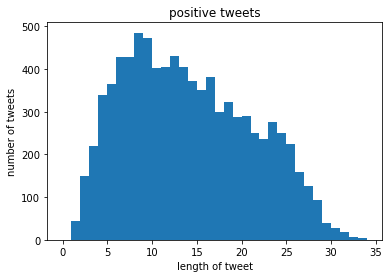

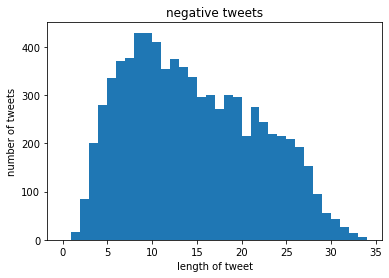

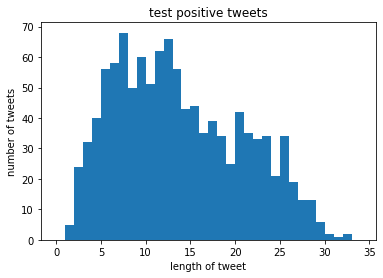

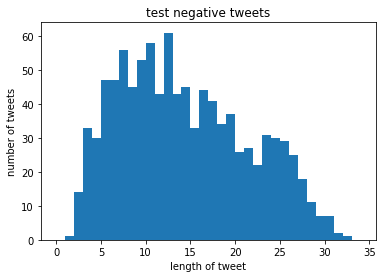

In [16]:
totalNumWords = [len(positive_tweets['clean_text'][index].split()) for index in positive_tweets.index]
plt.hist(totalNumWords,bins = np.arange(0,35,1))
plt.title('positive tweets')
plt.xlabel('length of tweet')
plt.ylabel('number of tweets')
plt.show()

totalNumWords = [len(negative_tweets['clean_text'][index].split()) for index in negative_tweets.index]
plt.hist(totalNumWords,bins = np.arange(0,35,1))
plt.title('negative tweets')
plt.xlabel('length of tweet')
plt.ylabel('number of tweets')
plt.show()

totalNumWords = [len(positive_tweets_test['clean_text'][index].split()) for index in positive_tweets_test.index]
plt.hist(totalNumWords,bins = np.arange(0,35,1))
plt.title('test positive tweets')
plt.xlabel('length of tweet')
plt.ylabel('number of tweets')
plt.show()

totalNumWords = [len(negative_tweets_test['clean_text'][index].split()) for index in negative_tweets_test.index]
plt.hist(totalNumWords,bins = np.arange(0,35,1))
plt.title('test negative tweets')
plt.xlabel('length of tweet')
plt.ylabel('number of tweets')
plt.show()

# instead of using a dictionary for nltk or spacy, we used the text from the training set and test set to make the dictionary

In [17]:
t1=pd.DataFrame({'A': positive_tweets.clean_text})
t2=pd.DataFrame({'A': positive_tweets.clean_selected})

t3=pd.DataFrame({'A': negative_tweets.clean_text})
t4=pd.DataFrame({'A': negative_tweets.clean_selected})

t5=pd.DataFrame({'A': positive_tweets_test.clean_text})
t6=pd.DataFrame({'A': negative_tweets_test.clean_text})

all_text_tokens=pd.concat([t1,t2,t3,t4,t5,t6],axis=0)
all_text_tokens.reset_index(inplace=True)

tokens_set=set()
for i in tqdm(all_text_tokens.index):
    tokens_set.update(all_text_tokens.A[i].split())


100%|██████████| 34830/34830 [00:01<00:00, 28157.94it/s]


In [18]:
# converting text into numerical tokens

max_word_dict = len(tokens_set)

tokenizer = Tokenizer(num_words=max_word_dict, lower=True, oov_token="<UKN>",filters='')
tokenizer.fit_on_texts(tokens_set)

vocab_size=len(tokenizer.word_index)+1

positive_tweets_train = tokenizer.texts_to_sequences(positive_tweets['clean_text'])
positive_selected_tokenize=tokenizer.texts_to_sequences(positive_tweets['clean_selected'])

negative_tweets_train = tokenizer.texts_to_sequences(negative_tweets['clean_text'])
negative_selected_tokenize=tokenizer.texts_to_sequences(negative_tweets['clean_selected'])

positive_test = tokenizer.texts_to_sequences(positive_tweets_test['clean_text'])
negative_test = tokenizer.texts_to_sequences(negative_tweets_test['clean_text'])

# The following function is used to create an array of 0's & 1's as the output of the NN. The 1's are placed in the indices of the words, which make up the selected text, in the input tweet 

In [19]:
def get_y_train(tokenized_selected_text_train,x_train):
    y_train=[]
    empty_selected=[]
    for i in range(len(x_train)):
        selected_text_array=np.array(tokenized_selected_text_train[i])
        if len(selected_text_array)==0:
            #print("empty selected text in index: ",i)
            empty_selected.append(i)
            selected_text=np.zeros(max_tweet_length)
            y_train.append(selected_text)
            continue
        first_word_indices=np.where(x_train[i]==selected_text_array[0])
        first_word_indices=np.array(first_word_indices)
        for j in first_word_indices[0]:
            start_index=j
            end_index=j+np.max(np.shape(selected_text_array))-1
            x_train_sub_array=x_train[i][start_index:end_index+1]
            if np.array_equal(x_train_sub_array,selected_text_array):
                break
        selected_text=np.zeros(max_tweet_length)
        selected_text[start_index:end_index+1]=1
        y_train.append(selected_text)
    y_train=np.array(y_train) 
    print("number of empty selected text: ",len(empty_selected))
    return y_train,empty_selected

# The following are all the hyperparameters in the model:

In [20]:
# length of input to NN
max_tweet_length=34

# embedding vector length of the embedding layer (should match the used vector length in the pretrained network)
embedding_vector_length=300

# number of units in LSTM layer 
HIDDEN_DIM=512

# LSTM L2 regularization parameter
lstm_l2=0.03

# dense layers number of units
dense_units=64

# dropout value
dropout_value=0.3

# loss used in cost function   (choose either "binary_crossentropy" or losses.SparseCategoricalCrossentropy())
model_loss="binary_crossentropy"

# batch size
batch_size=32

# number of epochs
epochs=34

# validation split of training data
validation_split=0.1

#learning metric      (choose either "accuracy" of "binary_accuracy")
learning_metric="binary_accuracy"

In [21]:
positive_x_train = pad_sequences(positive_tweets_train, maxlen=max_tweet_length)
negative_x_train = pad_sequences(negative_tweets_train, maxlen=max_tweet_length)

positive_x_test = pad_sequences(positive_test, maxlen=max_tweet_length)
negative_x_test = pad_sequences(negative_test, maxlen=max_tweet_length)

positive_y_train,positive_selected_empty=get_y_train(positive_selected_tokenize,positive_x_train)
negative_y_train,negative_selected_empty=get_y_train(negative_selected_tokenize,negative_x_train)

#positive_y_train=pad_sequences(positive_selected_tokenize, maxlen=max_tweet_length)
#negative_y_train=pad_sequences(negative_selected_tokenize, maxlen=max_tweet_length)

number of empty selected text:  0
number of empty selected text:  0


# We used a pre-trained network for the word embedding of our text. GloVe for twitter is used here

In [22]:
def load_glove():
    tqdm.pandas()
    f = open('../input/glove840b300dtxt/glove.840B.300d.txt')
    embedding_dict = {}
    for line in tqdm(f):
        word_emb=line.split(' ')
        word=word_emb[0]
        embedding_vector=np.array(word_emb[1:],dtype = 'float32')
        embedding_dict[word]=embedding_vector
    
    f.close()
    return embedding_dict

In [23]:
def fit_glove(tokenizer,embedding_dict,embedding_vector_length):
    
    vocab_size=len(tokenizer.word_index)+1
    
    all_embs = np.stack(embedding_dict.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embedding_matrix = np.random.normal(emb_mean, emb_std, (vocab_size, embedding_vector_length))
    
    out_of_dict=[]
    
    for word,value in tqdm(tokenizer.word_index.items()):
        embedding_vector=embedding_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[value]=embedding_vector
        else:
            out_of_dict.append(word)     
                
    print("number of words not in embedding dictionary: ", len(out_of_dict))        
    return embedding_matrix,out_of_dict

In [24]:
embedding_dict=load_glove()
embedding_matrix,out_of_embedding_dict=fit_glove(tokenizer,embedding_dict,embedding_vector_length)

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
2196018it [05:30, 6643.34it/s]
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|██████████| 19823/19823 [00:00<00:00, 278299.64it/s]

number of words not in embedding dictionary:  2672


In [25]:
print(out_of_embedding_dict[0:51])

['<UKN>', 'g1986', 'day<3', 'muahahahhahaha', 'darnitt', 'accela', 'ccrying', 'soberana', '_04071991', '(?)', 'fkc', 'dunners', '3..', '<3criminy', 'booklife', 'bradies', 'suuuks', 'ï¿½80', 'ouuuuuuuuuchhhhhhhh', 'mtfbwy', 'binstruct', 'chilliin', '1thing', 'yuuum', 'fitzcarraldo', 'saaaaaaid', 'grtsat', 'cnaterbury', 'nylana', 'oowwwww', 'rainging', 'tifanny', 'mygrilled', "...'", 'twitster', 'icurve', 'walwal', 'amazeeeeeee', 'offiacial', 'mayjah', 'mammyy', '((((((((((((((((((', 'ohay', '}:', '50%', 'cooolooorss', 'youregreat', 'sarrah', 'pachad', 'myweawkness', 'heelllll']


# Next is the model architecture

In [26]:

    
inputs_n = Input(shape=(max_tweet_length,), dtype='int32')

embedding_layer_n = Embedding(vocab_size, embedding_vector_length, weights=[embedding_matrix],trainable=False)
encoder_LSTM_n = Bidirectional(LSTM(HIDDEN_DIM,return_sequences=True,kernel_regularizer=regularizers.l2(lstm_l2)))
dense_layer_relu_n1 = TimeDistributed(Dense(dense_units, activation='relu'))
dense_layer_relu_n2 = TimeDistributed(Dense(dense_units, activation='relu'))
dense_layer_sigmoid_n = TimeDistributed(Dense(64, activation='sigmoid'))
Drop_n = TimeDistributed(Dropout(dropout_value))
dense_layer_n = TimeDistributed(Dense(1, activation='sigmoid'))

encoder_embedding_n = embedding_layer_n(inputs_n)
Encoded_seq_n = encoder_LSTM_n(encoder_embedding_n)
outputs_n = Drop_n(dense_layer_relu_n1(Encoded_seq_n))
outputs_n = Drop_n(dense_layer_relu_n2(outputs_n))
#outputs_n= Drop_n(dense_layer_sigmoid_n(outputs_n))
outputs_n = dense_layer_n(outputs_n)

negative_model = Model(inputs=inputs_n, outputs=outputs_n)  
negative_model.compile(optimizer='Adam', loss=model_loss,metrics=[learning_metric])
negative_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 300)      5947200     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 34, 1024)     3330048     embedding[0][0]                  
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 34, 64)       65600       bidirectional[0][0]              
______________________________________________________________________________________________

In [27]:
inputs_p = Input(shape=(max_tweet_length,), dtype='int32')

embedding_layer_p = Embedding(vocab_size, embedding_vector_length, weights=[embedding_matrix],trainable=False)
encoder_LSTM_p = Bidirectional(LSTM(HIDDEN_DIM,return_sequences=True,kernel_regularizer=regularizers.l2(lstm_l2)))
dense_layer_relu_p1 = TimeDistributed(Dense(dense_units, activation='relu'))
dense_layer_relu_p2 = TimeDistributed(Dense(dense_units, activation='relu'))
dense_layer_sigmoid_p = TimeDistributed(Dense(64, activation='sigmoid'))
Drop_p = TimeDistributed(Dropout(dropout_value))
dense_layer_p = TimeDistributed(Dense(1, activation='sigmoid'))

encoder_embedding_p = embedding_layer_p(inputs_p)
Encoded_seq_p = encoder_LSTM_p(encoder_embedding_p)
outputs_p = Drop_p(dense_layer_relu_p1(Encoded_seq_p))
outputs_p = Drop_p(dense_layer_relu_p2(outputs_p))
#outputs_p= Drop_p(dense_layer_sigmoid_p(outputs_p))
outputs_p = dense_layer_p(outputs_p)

positive_model = Model(inputs=inputs_p, outputs=outputs_p)  
positive_model.compile(optimizer='Adam', loss=model_loss,metrics=[learning_metric])
positive_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 300)      5947200     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 34, 1024)     3330048     embedding_1[0][0]                
__________________________________________________________________________________________________
time_distributed_5 (TimeDistrib (None, 34, 64)       65600       bidirectional_1[0][0]            
____________________________________________________________________________________________

In [28]:
if model_loss != "binary_crossentropy":
    y_train=np.reshape(negative_y_train,np.product(np.shape(negative_y_train)))
    print(np.shape(y_train))
    negative_y_train=y_train
    y_train=np.reshape(positive_y_train,np.product(np.shape(positive_y_train)))
    positive_y_train=y_train

In [29]:
## the inputs to the method fit() have to be arrays not lists
positive_model.fit(positive_x_train,positive_y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

Epoch 1/34
242/242 [==============================] - 103s 427ms/step - loss: 2.1274 - binary_accuracy: 0.8952 - val_loss: 0.2317 - val_binary_accuracy: 0.8976
Epoch 2/34
242/242 [==============================] - 100s 412ms/step - loss: 0.2264 - binary_accuracy: 0.9050 - val_loss: 0.2227 - val_binary_accuracy: 0.9018
Epoch 3/34
242/242 [==============================] - 100s 414ms/step - loss: 0.2194 - binary_accuracy: 0.9069 - val_loss: 0.2205 - val_binary_accuracy: 0.9061
Epoch 4/34
242/242 [==============================] - 103s 424ms/step - loss: 0.2171 - binary_accuracy: 0.9074 - val_loss: 0.2155 - val_binary_accuracy: 0.9072
Epoch 5/34
242/242 [==============================] - 103s 427ms/step - loss: 0.2145 - binary_accuracy: 0.9088 - val_loss: 0.2105 - val_binary_accuracy: 0.9084
Epoch 6/34
242/242 [==============================] - 99s 411ms/step - loss: 0.2111 - binary_accuracy: 0.9093 - val_loss: 0.2138 - val_binary_accuracy: 0.9071
Epoch 7/34
242/242 [=====================

In [30]:
## the inputs to the method fit() have to be arrays not lists
negative_model.fit(negative_x_train,negative_y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

Epoch 1/34
219/219 [==============================] - 88s 400ms/step - loss: 2.3224 - binary_accuracy: 0.8781 - val_loss: 0.2561 - val_binary_accuracy: 0.8778
Epoch 2/34
219/219 [==============================] - 87s 398ms/step - loss: 0.2487 - binary_accuracy: 0.8868 - val_loss: 0.2485 - val_binary_accuracy: 0.8851
Epoch 3/34
219/219 [==============================] - 96s 437ms/step - loss: 0.2431 - binary_accuracy: 0.8900 - val_loss: 0.2441 - val_binary_accuracy: 0.8887
Epoch 4/34
219/219 [==============================] - 87s 396ms/step - loss: 0.2413 - binary_accuracy: 0.8911 - val_loss: 0.2371 - val_binary_accuracy: 0.8904
Epoch 5/34
219/219 [==============================] - 86s 391ms/step - loss: 0.2457 - binary_accuracy: 0.8918 - val_loss: 0.2437 - val_binary_accuracy: 0.8865
Epoch 6/34
219/219 [==============================] - 86s 391ms/step - loss: 0.2366 - binary_accuracy: 0.8929 - val_loss: 0.2443 - val_binary_accuracy: 0.8853
Epoch 7/34
219/219 [==========================

In [31]:
negative_y_test=negative_model.predict(negative_x_train)
negative_y_test=np.around(negative_y_test)

positive_y_test=positive_model.predict(positive_x_train)
positive_y_test=np.around(positive_y_test)

In [32]:
print(np.transpose(negative_y_test[2]))
print(negative_y_train[2])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]


In [33]:
def convert_pred_index_into_selected_text(x,y,tweets_data,tokenizer):
    
    reverse_tokenizer=dict(map(reversed,tokenizer.word_index.items()))
    data_text_lower=[item.lower() for item in tweets_data.text]
    
    no_selected_text=0
    for i in range(len(tweets_data)):
        
## debugging
#        if i==7:
#            print("index number", i, "has the error")        
#            return
        
        actual_selected_words=[]
        
        tweets_data_index=tweets_data.index[i]        
        split_tweet=tweets_data.text[tweets_data_index].split()

        #filtered_split_tweet=[]
        
        # doing it this way instead of doing it without split solves this example:
        # (hello ... world), the "..." will be removed but it will still take an index 1 and world will take index 2
        # if split was not used, world will now take index 1
#        for j in range(len(split_tweet)):
#            filtered_split_tweet.append(remove_special_characters(split_tweet[j].lower()))
        
        filtered_split_tweet=remove_special_characters(tweets_data.text[tweets_data_index].lower())
        filtered_split_tweet=filtered_split_tweet.split()
        
        predicted_indices=np.where(y[i]==1)
        if len(predicted_indices[0])==0:
            tweets_data.selected_text[tweets_data_index]=""
            #print("no selected text for tweet in row: ",tweets_data_index, "index number: ",i)
            no_selected_text=no_selected_text+1
            continue
            
  
        for index in predicted_indices[0]:
            if x[i][index] !=0:
                selected_word=reverse_tokenizer.get(x[i][index])
                selected_word_index=get_index_word_in_string(selected_word,filtered_split_tweet)
                # np.where doesn't work with strings, even if split
                #selected_word_index=np.where(filtered_split_tweet==selected_word)
                
# the commented code is used for debugging  
        #        print(i)
#                if i==7:
#                    print("predicted words indices: ",predicted_indices[0])
#                    print("selected word: ", selected_word)
#                    print("filtered text: ",filtered_split_tweet)
#                    print("selected word index:", selected_word_index)
#                    return
###################################        
                if selected_word_index==-1:
                    print("there is an error in conversion for tweet row: ",tweets_data_index, "index number: ",i)
                elif len(selected_word_index)==1:                     
                    tweet_text_lower_split=tweets_data.text[tweets_data_index].lower().split()
                    update=0
                    for j in range(len(tweet_text_lower_split)):
                        found_word=tweet_text_lower_split[j].find(selected_word)
                        if found_word !=-1:
                            actual_selected_word=tweets_data.text[tweets_data_index].split()[j]
                            duplicate=0
                            for k in range(len(actual_selected_words)):
                                duplicate_found=get_index_word_in_string(actual_selected_word,actual_selected_words)
                                if duplicate_found !=-1:
                                    #print("duplicate found in row: ",tweets_data_index, "index number: ",i)
                                    duplicate=1
                                    update=1
                                    break
                            if duplicate !=1:
                                actual_selected_words.append(actual_selected_word)
                                update=1
                            break
                    if update ==0:
                        print("error in find for row: ",tweets_data_index, "index number: ",i)
                    #actual_selected_words.append(tweets_data.text[tweets_data_index].split()[selected_word_index[0]])
                elif len(selected_word_index)>1:
                    ## for now, we chose the word to be of the first index, but should be later updated to be smarter ##
                    #actual_selected_words.append(tweets_data.text[tweets_data_index].split()[selected_word_index[0]])
                    tweet_text_lower_split=tweets_data.text[tweets_data_index].lower().split()
                    update=0
                    for j in range(len(tweet_text_lower_split)):
                        found_word=tweet_text_lower_split[j].find(selected_word)
                        if found_word !=-1:
                            actual_selected_word=tweets_data.text[tweets_data_index].split()[j]
                            duplicate=0
                            for k in range(len(actual_selected_words)):
                                duplicate_found=get_index_word_in_string(actual_selected_word,actual_selected_words)
                                if duplicate_found !=-1:
                                    #print("duplicate found in row: ",tweets_data_index, "index number: ",i)
                                    duplicate=1
                                    update=1
                                    break
                            if duplicate !=1:
                                actual_selected_words.append(actual_selected_word)
                                update=1
                            break
                    if update ==0:
                        print("error in find for row: ",tweets_data_index, "index number: ",i)
# the commented code is used for debugging  
#        print(i)
#            if i==6:
#                print("predicted words indices: ",predicted_indices[0])
#                print("selected word: ", selected_word)
#                print("filtered text: ",filtered_split_tweet)
#                print("selected word index:", selected_word_index)
#                print("actual text split: ",tweets_data.text[tweets_data_index].split())
#                return
           
        actual_selected_text=" ".join(actual_selected_words)
        tweets_data.selected_text[tweets_data_index]=actual_selected_text      
        #selected_text=" ".join(selected_words)    
    print("total empty selected text: ",no_selected_text)
    return

In [34]:
def populate_test_selected_text(positive_tweets,negative_tweets,test_data):
    for i in tqdm(test_data.index):
        if test_data.sentiment[i]=="neutral":
            test_data.selected_text[i]=test_data.text[i]
            
        elif test_data.sentiment[i]=="positive":
            if positive_tweets.textID[i] != test_data.textID[i]:
                print("There is an error in indices for index: ",i)
                for j in positive_tweets.index:
                    if positive_tweets.textID[j] == test_data.textID[i]:
                        test_data.selected_text[i]=positive_tweets.selected_text[j]
                        break
            else:
                test_data.selected_text[i]=positive_tweets.selected_text[i]
                
        elif test_data.sentiment[i]=="negative":
            if negative_tweets.textID[i] != test_data.textID[i]:
                print("There is an error in indices for index: ",i)
                for j in negative_tweets.index:
                    if negative_tweets.textID[j] == test_data.textID[i]:
                        test_data.selected_text[i]=negative_tweets.selected_text[j]
                        break
            else:
                test_data.selected_text[i]=negative_tweets.selected_text[i]
                
    return
                                

In [35]:
positive_train_copy1=positive_tweets.copy()
convert_pred_index_into_selected_text(positive_x_train,positive_y_test,positive_train_copy1,tokenizer)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


total empty selected text:  182


In [36]:
negative_train_copy1=negative_tweets.copy()
convert_pred_index_into_selected_text(negative_x_train,negative_y_test,negative_train_copy1,tokenizer)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


total empty selected text:  178


In [37]:
train_copy_copy=train_copy.copy()
populate_test_selected_text(positive_train_copy1,negative_train_copy1,train_copy_copy)

  0%|          | 0/27480 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 27480/27480 

In [38]:
correct_train_copy=train.copy()
correct_train_copy.dropna(axis=0, how="any", inplace=True)
correct_train_copy.reset_index(inplace=True)

jaccard_list=[]
for i in correct_train_copy.index:
    correct_set=set(correct_train_copy.selected_text[i].split())
    predicted_set=set(train_copy_copy.selected_text[i].split())
    intersection=correct_set.intersection(predicted_set)
    jaccard= float(len(intersection)/(len(correct_set)+len(predicted_set)-len(intersection)))
    jaccard_list.append(jaccard)

average_jaccard=sum(jaccard_list)/len(jaccard_list)
print("average jaccard: ", average_jaccard)

average jaccard:  0.6670189013222584


In [39]:
negative_y_test=negative_model.predict(negative_x_test)
negative_y_test=np.around(negative_y_test)
negative_test_data_copy=negative_tweets_test.copy()
convert_pred_index_into_selected_text(negative_x_test,negative_y_test,negative_test_data_copy,tokenizer)

positive_y_test=positive_model.predict(positive_x_test)
positive_y_test=np.around(positive_y_test)
positive_test_data_copy=positive_tweets_test.copy()
convert_pred_index_into_selected_text(positive_x_test,positive_y_test,positive_test_data_copy,tokenizer)
test_data_copy=test.copy()
populate_test_selected_text(positive_test_data_copy,negative_test_data_copy,test_data_copy)

total empty selected text:  28


 13%|█▎        | 472/3534 [00:00<00:00, 4716.99it/s]

total empty selected text:  24


100%|██████████| 3534/3534 [00:00<00:00, 4581.62it/s]


In [40]:
print("jaccard score between text and selected text for test set:")
#sentiment jaccard score
positive_test_jaccard=get_jaccard(positive_test_data_copy)
print("positive sentiments jaccard score: ",positive_test_jaccard)
negative_test_jaccard=get_jaccard(negative_test_data_copy)
print("negative sentiments jaccard score: ",negative_test_jaccard)

jaccard score between text and selected text for test set:
positive sentiments jaccard score:  0.21959146157147869
negative sentiments jaccard score:  0.23278539219454072


In [41]:
def csv_submission(test_data):
    submission_data={"textID":test_data.textID,
               "selected_text":test_data.selected_text,
    }
    test_csv=pd.DataFrame(submission_data,columns=["textID","selected_text"])
    test_csv.to_csv('submission.csv',index=False)
    return

In [42]:
csv_submission(test_data_copy)